<a href="https://colab.research.google.com/github/quockhanhdao/Lung_Tumours_Segmentation/blob/main/Lung_Cancer_Segmentation_(custom_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"
!pip install neptune-client torch torchvision

# Initialize model type (neptune.ai)

In [2]:
import neptune.new as neptune

model = neptune.init_model(
    name = "LTS",
    key = "UNET", 
    project = "khanh.daoquoc/Lung-Tumours-Segmentation", 
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3Mjg4YTFkMy05ODlmLTQ3OWUtOWJhZS0yYjk5YmJlMmQ2NTMifQ==",
)

https://app.neptune.ai/khanh.daoquoc/Lung-Tumours-Segmentation/m/LUNG-UNET
Remember to stop your model once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/model#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Import libraries

In [3]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

import monai
from monai.apps import DecathlonDataset
from monai.data import DataLoader, decollate_batch
from monai.utils import first
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensityD,
    ResizeD,
    RandAffineD,
    ToTensorD,
    AsDiscrete
)

import torch
from torch import nn
from torch.nn import (
    Conv3d,
    ConvTranspose3d,
    MaxPool3d,
    ModuleList,
    ReLU,
    functional,
    Dropout,
)
from torchvision.transforms import CenterCrop

import math
import numpy as np
import matplotlib.pyplot as plt

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


# Help function

In [24]:
def CenterCrop3D(arr, size):
  (_, _, h, w, d) = arr.shape
  pad_h = math.floor((h - size[0]) / 2)
  pad_w = math.floor((w - size[1]) / 2)
  pad_d = math.floor((d - size[2]) / 2)
  return arr[:, :, (pad_h):(pad_h + size[0]), (pad_w):(pad_w + size[1]), (pad_d):(pad_d + size[2])]

class DiceMetric(nn.Module):
  def __init__(self, smooth = 0.001, sigmoid = False, softmax = False):
    super(DiceMetric, self).__init__()
    self.smooth = smooth
    self.sigmoid = sigmoid
    self.softmax = softmax

  def forward(self, preds, targets):
    if self.sigmoid:
      preds = torch.nn.Sigmoid()(preds)
    elif self.softmax:
      preds = torch.nn.Softmax(1)(preds)

    # Reduce batch-axis and channel-axis (classes-axis)
    preds = preds[0, 0]
    targets = targets[0, 0]

    # Flatten label and prediction tensors
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    intersection = (preds * targets).sum()
    dice = (2 * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

    return dice

# Track model (neptune.ai)

In [5]:
run = neptune.init(
    project = "khanh.daoquoc/Lung-Tumours-Segmentation",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3Mjg4YTFkMy05ODlmLTQ3OWUtOWJhZS0yYjk5YmJlMmQ2NTMifQ==",
)

https://app.neptune.ai/khanh.daoquoc/Lung-Tumours-Segmentation/e/LUNG-11
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Load data

## Test data

In [6]:
# Dowload data, src: http://medicaldecathlon.com/
dataset = DecathlonDataset(root_dir = "./", 
                           task = "Task06_Lung", section = "training", 
                           transform = None, download = True)
print(f"\nNumber of subjects: {len(dataset)}.\nThe first element in the dataset is {dataset[0]}.")

Task06_Lung.tar: 8.53GB [06:04, 25.2MB/s]                            

2022-09-05 16:26:15,747 - INFO - Downloaded: Task06_Lung.tar


2022-09-05 16:26:58,591 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2022-09-05 16:26:58,592 - INFO - Writing into directory: ..


Loading dataset: 100%|██████████| 51/51 [00:00<00:00, 95751.79it/s]


Number of subjects: 51.
The first element in the dataset is {'image': 'Task06_Lung/imagesTr/lung_014.nii.gz', 'label': 'Task06_Lung/labelsTr/lung_014.nii.gz'}.


In [7]:
# Load data to check
loader = LoadImageD(keys=("image", "label"))
data_check = loader({"image": "Task06_Lung/imagesTr/lung_014.nii.gz",
                     "label": "Task06_Lung/labelsTr/lung_014.nii.gz"})
print(f"Image shape: {data_check['image'].shape} \nLabel shape: {data_check['label'].shape}")

Image shape: (512, 512, 589) 
Label shape: (512, 512, 589)


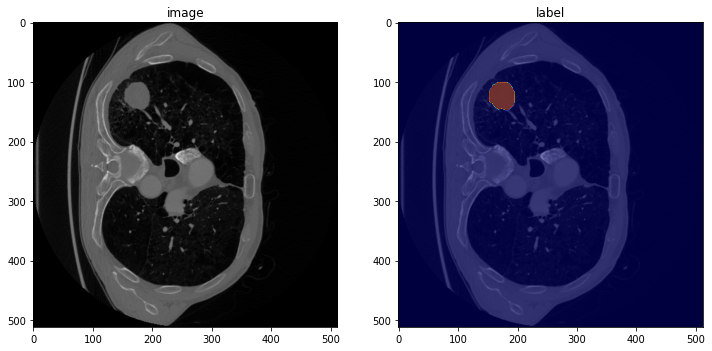

In [8]:
# Visualize check image and label
slide = 379
plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")
plt.imshow(data_check['label'][:, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

## Load training set

In [9]:
# Set up transform
KEYS = ["image", "label"]

transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, 
             pixdim = (1., 1., 1.), 
             mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, 
            (128, 128, 64), 
            mode = ('trilinear', 'nearest')),
    RandAffineD(keys = KEYS, 
                spatial_size = (128, 128, 96),
                rotate_range = (0, 0, np.pi/12),
                scale_range = (0.1, 0.1, 0.1),
                mode = ('bilinear', 'nearest'),
                prob = 1.0),
    ToTensorD(KEYS),
])

# Load data
dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "training",
                           transform = transform, download = True)

train_loader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 4)

2022-09-05 16:28:58,225 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2022-09-05 16:28:58,229 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2022-09-05 16:28:58,231 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 51/51 [10:03<00:00, 11.82s/it]


In [10]:
# Check training set
print(f"Length of training set: {len(train_loader)}")

check_training = first(train_loader)
training_image, training_label = check_training['image'], check_training['label']
print(f"check data training image shape: {training_image.shape} \ncheck data training label shape: {training_label.shape}")

Length of training set: 51
check data training image shape: (1, 1, 128, 128, 96) 
check data training label shape: (1, 1, 128, 128, 96)


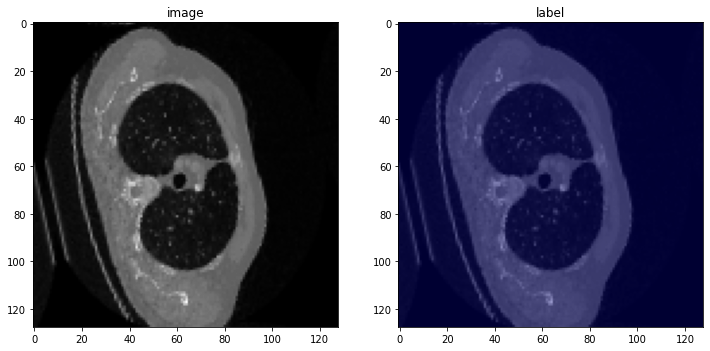

In [11]:
# Visualize training data
slide = 60
plt.figure("Training Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(training_image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(training_image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(training_label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.4)

plt.show()

## Load validation set

In [12]:
# Set up transform
val_transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, pixdim = (1., 1., 1.), mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, (128, 128, 96), mode = ('trilinear', 'nearest')),
    ToTensorD(KEYS),
])

# Load data
val_dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "validation",
                           transform = val_transform, download = True)

val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 4)

2022-09-05 16:39:47,353 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2022-09-05 16:39:47,355 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2022-09-05 16:39:47,361 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 12/12 [02:25<00:00, 12.10s/it]


In [13]:
# Check validation set
print(f"Length of validation set: {len(val_loader)}")

check_val = first(val_loader)
val_image, val_label = check_val['image'], check_val['label']
print(f"check data image shape: {val_image.shape} \ncheck data label shape: {val_label.shape}")

Length of validation set: 12
check data image shape: (1, 1, 128, 128, 96) 
check data label shape: (1, 1, 128, 128, 96)


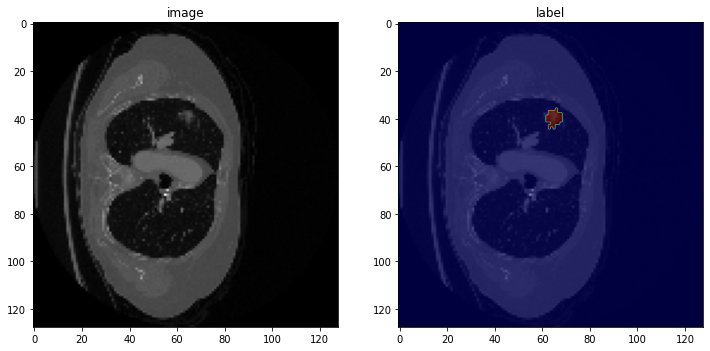

In [14]:
# Visualize validation data
slide = 66
plt.figure("Validation Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(val_image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(val_image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(val_label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

# Model, Loss, Optimizer

## Creat model version (neptune.ai)

In [15]:
model_version = neptune.init_model_version(
    model = "LUNG-UNET",
    project = "khanh.daoquoc/Lung-Tumours-Segmentation",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3Mjg4YTFkMy05ODlmLTQ3OWUtOWJhZS0yYjk5YmJlMmQ2NTMifQ==",
)

https://app.neptune.ai/khanh.daoquoc/Lung-Tumours-Segmentation/m/LUNG-UNET/v/LUNG-UNET-1
Remember to stop your model_version once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/model-version#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Construct model

### Block

In [16]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    # store the convolution and ReLU layers
    self.conv1 = Conv3d(in_channels = in_channels, out_channels = out_channels, 
                        kernel_size = 3, stride = 1, padding = 1)
    self.relu = ReLU()
    self.conv2 = Conv3d(in_channels = out_channels, out_channels = out_channels, 
                        kernel_size = 3, stride = 1, padding = 1)
    
  def forward(self, x):
    return self.relu(self.conv2(self.relu(self.conv1(x))))

### Encoder

In [17]:
class Encoder(nn.Module):
  def __init__(self, drop_out = 0.5, channels = (1, 32, 64, 128)):
    super().__init__()
    # store the encoder blocks and maxpooling layer
    self.encoder_blocks = ModuleList(
        [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
    )
    self.drop = Dropout(p = drop_out)
    self.pool = MaxPool3d(kernel_size = 2)

  def forward(self, x):
    # initialize an empty list to store the intermediate outputs
    block_outputs = []
    # loop through the encoder blocks
    for block in self.encoder_blocks:
      # pass the inputs through the current encoder block
      # store the outputs, then apply maxpooling on the output
      x = block(x)
      block_outputs.append(x)
      x = self.pool(x)
      x = self.drop(x)
    # return the list containing the intermediate outputs
    return block_outputs

### Decoder

In [18]:
class Decoder(nn.Module):
  def __init__(self, drop_out = 0.5, channels = (128, 64, 32)):
    super().__init__()
    # initialize the number of channels, upsampler and decoder blocks
    self.channels = channels
    self.drop = Dropout(p = drop_out)
    self.up_convs = ModuleList(
        [ConvTranspose3d(in_channels = channels[i], out_channels = channels[i + 1], 
                         kernel_size = 2, stride = 1) for i in range(len(channels) - 1)]
    )
    self.decoder_blocks = ModuleList(
        [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
    )

  def crop(self, encoder_features, x):
      # grab the dimensions of input x,
      # then crop the encoder features to match those dimensions
      (_, _, H, W, D) = x.shape
      result = CenterCrop3D(encoder_features, [H, W, D])
      # return the cropped features
      return result

  def forward(self, x, encoder_features):
    # loop through the number of channels
    for i in range(len(self.channels) - 1):
      # pass the inputs through the upsampler blocks
      x = self.up_convs[i](x)
      # crop the current features from the encoder blocks,
      # concatenate them with the curent upsampled features (along the channel dimension),
      # pass the concatenated output through the current decoder block
      encFeat = self.crop(encoder_features[i], x)
      x = torch.cat([x, encFeat], dim = 1) # which dimension???
      x = self.drop(x)
      x = self.decoder_blocks[i](x)
    # return the final decoder output
    return x

### UNet

In [19]:
class UNet(nn.Module):
  def __init__(self, drop_out = 0.5, channels = (1, 32, 64, 128)):
    super().__init__()
    encoder_channels = channels
    decoder_channels = []
    counter = len(channels) - 1
    while counter > 0:
      decoder_channels.append(channels[counter])
      counter -= 1
    # initalize the encoder and decoder
    self.encoder = Encoder(drop_out, encoder_channels)
    self.decoder = Decoder(drop_out, decoder_channels)
    # initialize the regression head and store the class variables
    self.out = Conv3d(in_channels = decoder_channels[-1], out_channels = 1,
                       kernel_size = 1, stride = 1, padding = 1)
  
  def forward(self, x):
    out_size = x.shape[2:5]
    # grab the features from the encoder
    encoder_features = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decoder_features = self.decoder(
        encoder_features[-1],
        encoder_features[::-1][1:]
    )
    # pass the decoder features through the regression head
    # to obtain the segmentation mask
    map = self.out(decoder_features)
    # resize the output to match the input shape
    map = nn.functional.interpolate(map, out_size)
    return map

## Construct loss function

### Dice Loss

In [25]:
class DiceLoss(nn.Module):
  def __init__(self, smooth = 0.001, sigmoid = False, softmax = False):
    super(DiceLoss, self).__init__()
    self.smooth = smooth
    self.sigmoid = sigmoid
    self.softmax = softmax

  def forward(self, preds, targets):
    if self.sigmoid:
      preds = torch.nn.Sigmoid()(preds)
    elif self.softmax:
      preds = torch.nn.Softmax(1)(preds)

    # Reduce batch-axis and channel-axis (classes-axis)
    preds = preds[0, 0]
    targets = targets[0, 0]

    # Flatten label and prediction tensors
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    intersection = (preds * targets).sum()
    dice = (2 * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

    return 1 - dice

## Configuration

In [33]:
config = {
    'channels' : (1, 64, 128, 256, 512),
    'drop_out' : 0.2,

    'learning_rate' : 0.0001,
    'decay_lr' : True,
    'decay_rate' : 0.1,
    'decay_step' : 10,

    'epoch' : 100,
    'val_interval' : 1
}

run["parameters"] = config
model_version["parameters"] = config

## Setup model

In [34]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

model = UNet(drop_out = config['drop_out'], channels = config['channels']).to(device)
print(model)

loss_function = DiceLoss(sigmoid = True)
optimizer = torch.optim.Adam(model.parameters(), lr = config['learning_rate'])
dice_metric = DiceMetric(sigmoid = True)
if config['decay_lr']:
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = config['decay_step'], gamma = config['decay_rate'])

UNet(
  (encoder): Encoder(
    (encoder_blocks): ModuleList(
      (0): Block(
        (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (relu): ReLU()
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (1): Block(
        (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (relu): ReLU()
        (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (2): Block(
        (conv1): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (relu): ReLU()
        (conv2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (3): Block(
        (conv1): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (relu): ReLU()
        (conv2): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    

# Start training

In [ ]:
loss_values = []
metric_values = []
best_metric = -1
best_metric_epoch = -1

print("Start training the network...")

for epoch in range(config['epoch']):
  print("-" * 13)
  print(f"Epoch {epoch + 1}/{config['epoch']}")

  # Turn model to "train" mode
  model.train()

  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1

    input, label = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )

    optimizer.zero_grad()
    output = model(input)
    loss = loss_function(output, label)
    loss.backward() # Compute gradient
    optimizer.step() # Update model's parameters

    epoch_loss += loss.item()
    print(f"{step}/{len(dataset) // train_loader.batch_size}, "
          f"train_loss: {loss.item():4f}")
    
  epoch_loss /= step
  loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  # Track train loss
  run["train/loss"].log(epoch_loss)
  model_version["train/loss"].log(epoch_loss)

  # Decay learning rate if decay_lr = True
  if config['decay_lr']:
    scheduler.step()

  if (epoch + 1) % config['val_interval'] == 0:
    # Turn model to "eval" mode
    model.eval()

    with torch.no_grad():
      metric = 0
      step_val = 0
      for val_data in val_loader:
        step_val += 1

        val_input, val_label = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        
        val_output = model(val_input)
        val_output = torch.round(val_output)
        curr_metric = dice_metric(val_output, val_label)
        metric += curr_metric.item()

      metric /= step_val
      metric_values.append(metric)
      
      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        print("Saved new best metric model!!!")
        torch.save(model.state_dict(), "best_metric_model.pth")

      print(
          f"current epoch: {epoch + 1},"
          f" current mean dice: {metric:.4f},"
          f" best mean dice: {best_metric:.4f},"
          f" at epoch: {best_metric_epoch}"
      )

      # Track train dice metric
      run["train/dice"].log(metric)
      model_version["train/dice"].log(metric)

print(
    f"train completed, best metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)

In [36]:
# Track best dice metric and stop 'run'
run["best dice"] = best_metric
model_version["best_dice"] = best_metric
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/khanh.daoquoc/Lung-Tumours-Segmentation/e/LUNG-11


# Check model

In [37]:
checker = first(train_loader)
image, label = checker['image'], checker['label']

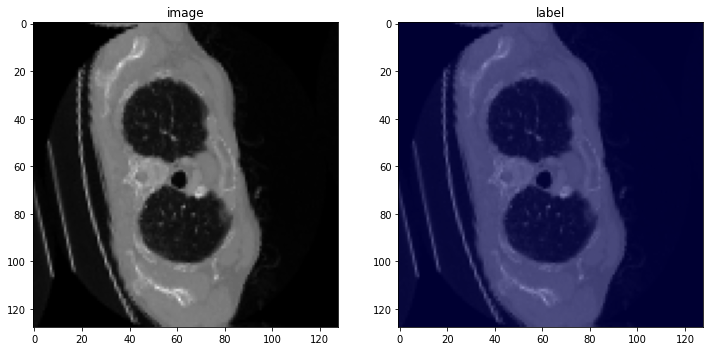

In [38]:
# Visualize training data
slide = 65
plt.figure("Training Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.4)

plt.show()

Output shape: (1, 1, 128, 128, 96)


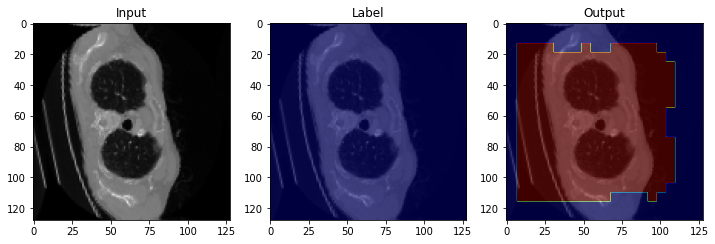

In [41]:
model.cpu()
model.load_state_dict(torch.load("best_metric_model.pth"))

with torch.no_grad():
  output = model(image)
  output = torch.nn.Sigmoid()(output)
  output = torch.round(output)
  print(f"Output shape: {output.shape}")

  slide = 65
  plt.figure("Test Model", (12, 12))

  plt.subplot(1, 3, 1)
  plt.title("Input")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

  plt.subplot(1, 3, 2)
  plt.title("Label")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.subplot(1, 3, 3)
  plt.title("Output")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(output[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.show()